In [ ]:
from google.colab import files
uploaded = files.upload()   # Διάλεξε "Regular Season.xlsx"


Saving Regular Season.xlsx to Regular Season.xlsx


In [ ]:
!pip install openpyxl seaborn tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
df = pd.read_excel("Regular Season.xlsx")

# Season != 10
reg_ssn = df[df["Season"] != 10].copy()

# Οι 12 σημαντικές μεταβλητές σου
feature_cols = [
    "Points", "2PT %", "3PT %", "DR", "TR", "TO",
    "BLKA", "FD", "PIR", "AST/TO", "TS %", "eFG %"
]

X = reg_ssn[feature_cols].copy()

# Target variable → factor στην R → 0/1 εδώ
y = reg_ssn["Playoffs / Quarter-Finals"].astype(int)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.30,          # 70% train
    random_state=25,
    stratify=y
)


In [ ]:
input_dim = X_train.shape[1]   # πόσα features έχεις
print(input_dim)

12


In [ ]:
input_dim = X_train.shape[1]   # πόσα features έχεις

# 🔹 ΜΟΝΟ 1 hidden layer
model = keras.Sequential([
    keras.layers.Dense(
        16, activation='relu',
        kernel_regularizer=keras.regularizers.l2(1e-4),
        input_shape=(input_dim,)
    ),
    keras.layers.Dropout(0.25),          # λίγο dropout για overfitting
    keras.layers.Dense(1, activation='sigmoid')   # έξοδος (0–1)
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.AUC(name='auc'),
        'accuracy'
    ]
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5775 - auc: 0.6302 - loss: 0.6849 - val_accuracy: 0.6750 - val_auc: 0.7520 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6789 - auc: 0.6690 - loss: 0.6656 - val_accuracy: 0.7000 - val_auc: 0.7680 - val_loss: 0.5628 - learning_rate: 0.0010
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6020 - auc: 0.6558 - loss: 0.6555 - val_accuracy: 0.7500 - val_auc: 0.7733 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6647 - auc: 0.7176 - loss: 0.5957 - val_accuracy: 0.7500 - val_auc: 0.7867 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6477 - auc: 0.6917 - loss: 0.6165 - val_accuracy: 0.7500 - val_auc: 0.7920 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6500 - auc: 0.7041 - loss:

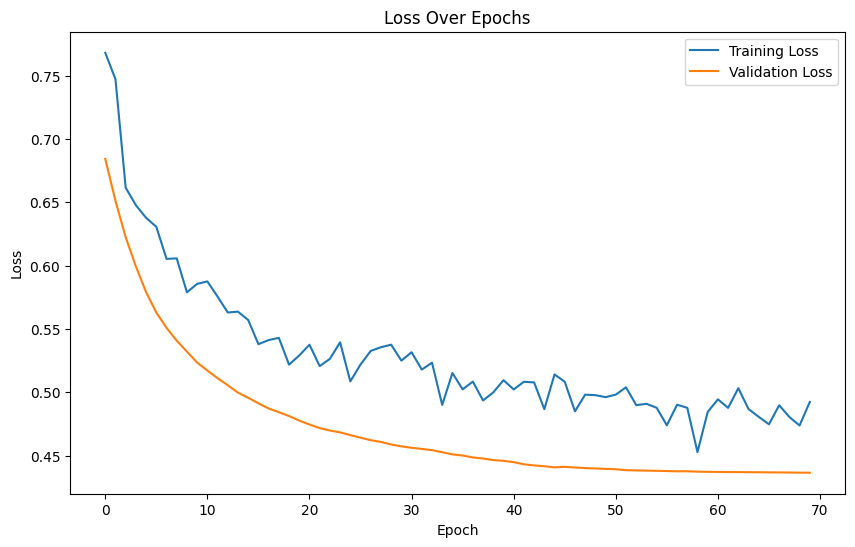

In [ ]:
import matplotlib.pyplot as plt

# --- LOSS ---
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


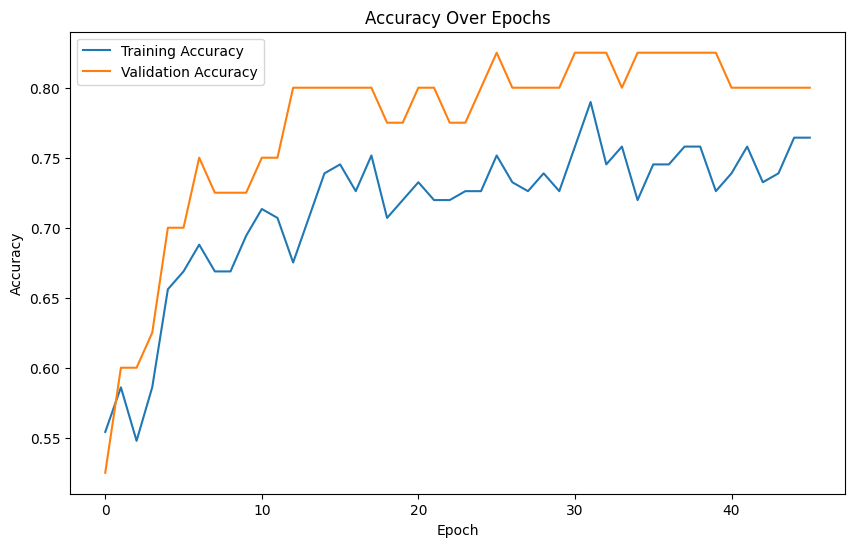

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

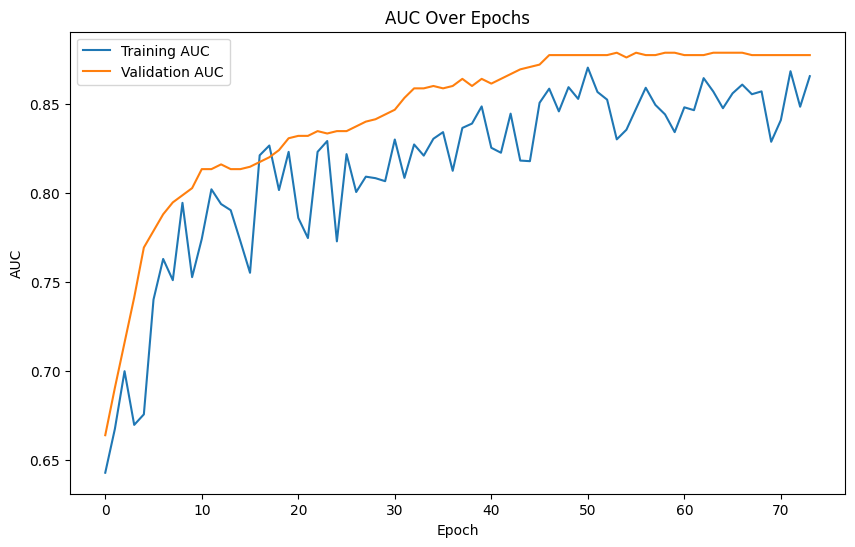

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Confusion Matrix:
 [[43  8]
 [ 7 27]]


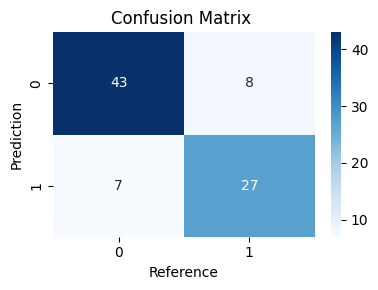

In [ ]:
y_prob = model.predict(X_test).ravel()      # πιθανότητες 0–1
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Reference")
plt.ylabel("Prediction")
plt.title("Confusion Matrix ")
plt.tight_layout()
plt.show()

In [ ]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

print("TN =", TN, "FP =", FP, "FN =", FN, "TP =", TP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2 * precision * recall) / (precision + recall)

print("Accuracy :", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall   :", round(recall, 3))
print("F1-score :", round(f1, 3))
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)
auc_value = roc_auc_score(y_test, y_prob)
print("AUC :", round(auc_value, 3))

TN = 43 FP = 8 FN = 7 TP = 27
Accuracy : 0.824
Precision: 0.771
Recall   : 0.794
F1-score : 0.783
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
AUC : 0.914


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


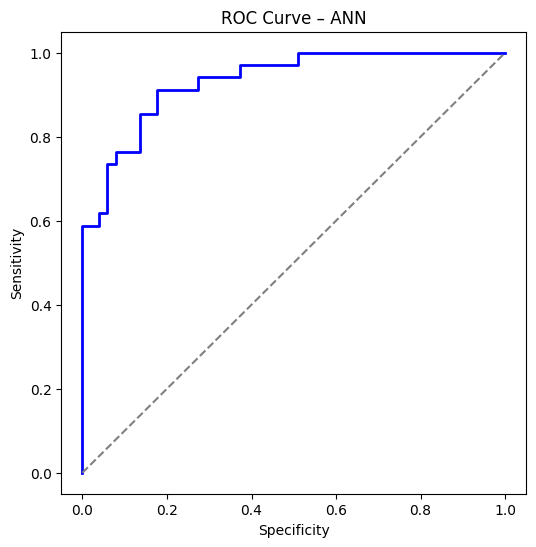

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# πιθανότητες (όχι τα predicted labels!)
y_prob = model.predict(X_test).ravel()

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_value = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = {:.3f}'.format(auc_value))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve – ANN")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.show()


In [ ]:
# Φιλτράρουμε μόνο τη σεζόν 15
season15 = df[df["Season"] == 15].copy()

# Χρησιμοποιούμε τα ίδια features
X_15 = season15[feature_cols].copy()

# Πολύ σημαντικό: ΔΕΝ ξανακάνουμε fit τον scaler
X_15_scaled = scaler.transform(X_15)

# Πιθανότητες πρόκρισης
prob_15 = model.predict(X_15_scaled).ravel()

# Binary prediction με threshold 0.5
pred_15 = (prob_15 >= 0.5).astype(int)

# Τα βάζουμε όλα σε DataFrame για παρουσίαση
pred_df = pd.DataFrame({
    "Team": season15["Team id"],
    "Season": season15["Season"],
    "Prediction": pred_15,
    "Probability": prob_15
}).sort_values("Probability", ascending=False)

print(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
     Team  Season  Prediction  Probability
294    16      15           1     0.898924
297    19      15           1     0.877239
293    15      15           1     0.805346
288    20      15           1     0.802919
284    53      15           1     0.783378
283     9      15           1     0.768036
290    10      15           1     0.724056
287     1      15           1     0.635505
292    13      15           1     0.632909
286    36      15           1     0.535047
295    55      15           1     0.535035
289    37      15           1     0.505765
285     5      15           0     0.470520
291    51      15           0     0.447770
299    24      15           0     0.367920
296    17      15           0     0.344686
298    54      15           0     0.273676
282    31      15           0     0.059599
